In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lifetimes

In [ ]:
## Importing libraries
import pandas as pd
import matplotlib.pyplot as plt


from lifetimes.plotting import *
from lifetimes.utils import *

## lifetime related figures
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases


In [ ]:
## Importing Data
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Online Retail.xlsx") 
# encoding = "cp1252" -- is called latent one encoding, helps in reading the data, even if there are some invalid characters. Remove 'code page' based data set
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Exploring the data

In [ ]:
data.shape

(541909, 8)

In [ ]:
## Finding the missing rows per column
data.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
## Invoice date holds time as well, we need to remove the time part
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format="%m/%d/%Y %H:%M").dt.date
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [ ]:
## As customer ID is our main field in CLV, we will drop those rows where customerID is null
# pd.notnull(data['CustomerID']) # returns true for those rows where CustomerID is not null
data = data[pd.notnull(data['CustomerID'])]
data.isnull().sum(axis=0) #column wise null values

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
data[(data['Quantity'] < 0)].count() # There are almost 8905 records which hold negative quantity values {junk}

InvoiceNo      8905
StockCode      8905
Description    8905
Quantity       8905
InvoiceDate    8905
UnitPrice      8905
CustomerID     8905
Country        8905
dtype: int64

In [ ]:
data[(data['Quantity'] < 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,17548.0,United Kingdom


In [ ]:
# keeping records with non-negative quantity
data = data[(data['Quantity'] > 0)]
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [ ]:
## We need a new column to give us the sum total of sales value
data['Total_Sales'] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [ ]:
## for customer lifecycle analysis, we only need specific set of columns
reqd_cols = ['CustomerID', 'InvoiceDate', 'Total_Sales']
data = data[reqd_cols]
data.head()

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [ ]:
## checking the unique number of customers after dropping records with null customer
print(data['CustomerID'].nunique())

4339


In [ ]:
## the last order date in data-frame
latest_order_date = data['InvoiceDate'].max()
print(latest_order_date)

## first records in our date frame
print("\n\n")
print(data.iloc[0,:])

## checking recency by using recency formula in CLV
print("\n\n")
print(latest_order_date - data.iloc[0,1])

2011-12-09



CustomerID        17850.0
InvoiceDate    2010-12-01
Total_Sales          15.3
Name: 0, dtype: object



373 days, 0:00:00


#### Lifetimes - BG/NBD model building and evaluation

In [ ]:
# CLV can be used to help us focus our attention on retaining the most important customers (and acquiring others like them)
# Here we’re going to use two different models - 
    ## the Beta Geometric Negative Binomial Distribution or BG/NBD model:: helps to calculate the expected number of transactions
    ## Gamma-Gamma model :: helps to calculate the revenue per transactions
    
# to predict the following:
    # Which customers are still customers
    # Who will order again in the next period
    # The number of orders each customer will place
    # The average order value of each customer’s order
    # The total amount each customer will generate for the business

In [ ]:
## Recency using lifetimes is calculated per customer with formula: data.InvoiceDate.max() - data.InvoiceDate.min(); data grouped by customerID
    ## here the higher the value, the better

## But when we manually calculated recency it was using formula:
## last_date_inData = data.InvoiceDate.max()
## last_date_inData - data.InvoiceDate.max()_per_customer
    ## here the lower the value, the better


In [ ]:
## Using lifetime package, and it's in-built functions to transform the transactional data (one row per purchase) into summary data (frequency, recency, age or Tenure, monetary)
lifetimes_summary_data = summary_data_from_transaction_data(data, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', observation_period_end='2011-12-09')
lifetimes_summary_data.head() # here customer ID will act as index

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [ ]:
lifetimes_summary_data_reset_index = lifetimes_summary_data.reset_index().head()
lifetimes_summary_data_reset_index.head() # here CustomerID will become one column, and 0-n will be our index

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


In [ ]:
## Frequency/Recency Analysis using the BG/NBD Model
## to fit the model we only need 'frequency', 'recency' and 'T' data
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(lifetimes_summary_data['frequency'], lifetimes_summary_data['recency'], lifetimes_summary_data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


In [ ]:
## Predicting future transaction in next 10 days and figuring out top 10 customers that the model expects them to make purchases

days = 10

lifetimes_summary_data['pred_10_days_transactions'] = bgf.conditional_expected_number_of_purchases_up_to_time(days, 
                                                                                                              lifetimes_summary_data['frequency'], 
                                                                                                              lifetimes_summary_data['recency'], 
                                                                                                              lifetimes_summary_data['T'])

lifetimes_summary_data['pred_10_days_transactions'] = round(lifetimes_summary_data['pred_10_days_transactions'])

lifetimes_summary_data.sort_values(by='pred_10_days_transactions', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_10_days_transactions
0,14911.0,131.0,372.0,373.0,1093.661679,3.0
1,17841.0,111.0,372.0,373.0,364.452162,3.0
2,12748.0,113.0,373.0,373.0,298.360885,3.0
3,15311.0,89.0,373.0,373.0,677.729438,2.0
4,14606.0,88.0,372.0,373.0,135.890114,2.0
5,12971.0,70.0,369.0,372.0,159.211286,2.0
6,13089.0,65.0,367.0,369.0,893.714308,2.0
7,17811.0,37.0,329.0,333.0,206.804324,1.0
8,16168.0,24.0,359.0,369.0,146.325000,1.0
9,17961.0,34.0,351.0,372.0,34.379118,1.0


In [ ]:
## predicting future transactions for next 10 days for a particular customer using predict() method

days = 100
individual_details = lifetimes_summary_data.reset_index().iloc[10,:]
print(individual_details)
print("\n")
print(round(bgf.predict(days, individual_details['frequency'], individual_details['recency'], individual_details['T'])))


## Based on his past data, the algorithm has predicted that the particular user will do 1 transaction in future 100 days

CustomerID                   12357.0
frequency                        0.0
recency                          0.0
T                               33.0
monetary_value                   0.0
pred_10_days_transactions        0.0
Name: 10, dtype: float64


1


In [ ]:
## predicting future transactions for next 10 days for a particular customer using predict() method

days = 100
individual_details2 = lifetimes_summary_data.loc[14911.0,:]

print(individual_details2)
print("\n")
print(round(bgf.predict(days, individual_details2['frequency'], individual_details2['recency'], individual_details2['T'])))


## Based on his past data, the algorithm has predicted that the particular user will do 30 transactions in future 100 days. This is because the use has done recent transaction and the frequency is quite high

frequency                     131.000000
recency                       372.000000
T                             373.000000
monetary_value               1093.661679
pred_10_days_transactions       3.000000
Name: 14911.0, dtype: float64


30


#### Plotting to get various insights over lifetime dataframe and BG/NBD model
* With 'inline' backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64


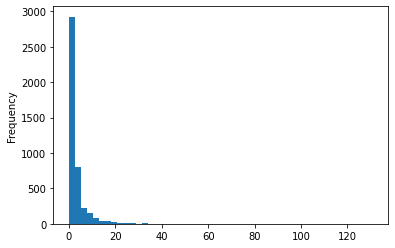

In [ ]:
%matplotlib inline

## Creating histogram to find out how many customers purchased item only once.
lifetimes_summary_data['frequency'].plot(kind='hist', bins=50)
print(lifetimes_summary_data['frequency'].describe()) # 25% of customers are clearly 1 timers, but the count could be higher

In [ ]:
## percentage of one timers -- whose frequency and recency would be zero
one_time_buyers = sum(lifetimes_summary_data['frequency'] == 0) / float(len(lifetimes_summary_data))

one_time_buyers_percentage = round(one_time_buyers * 100, 2)

print(one_time_buyers_percentage)

35.7


In [ ]:
## one time customers using recency value
one_time_buyers = sum(lifetimes_summary_data['recency'] == 0) / float(len(lifetimes_summary_data))
one_time_buyers_percentage = round(one_time_buyers * 100, 2)
print(one_time_buyers_percentage)

35.7


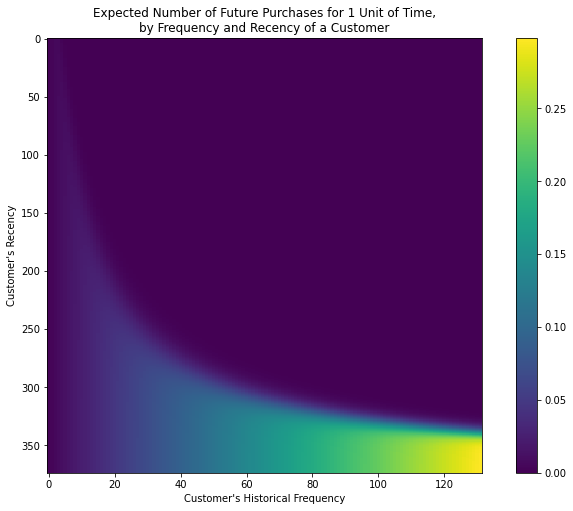

In [ ]:
%matplotlib inline

## Interesting points:
##	1. this matrix has customer's recency on y-axis; frequency on x-axis
##	2. the heatmap shows the predicted number of future purchases customers, in one unit of time.
##	3. So the customers most likely to order are those who've placed lots of previous orders and have been seen relatively recently.


## Visualizing frequency/recency matrix
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

## Observations:
    ## with higher historical frequency and higher customer recency we get the best set of customers

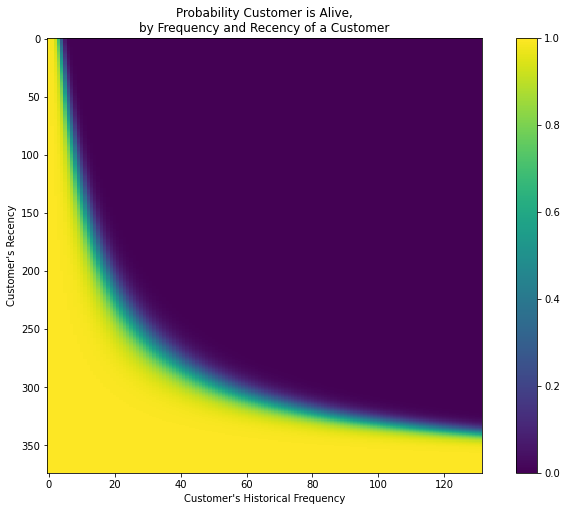

In [ ]:
## predicting if the customers are alive or not
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf) 

# Observations:
    # we can see tail (thick yellow portion) at lower frequency values and higher recency values: representing those customer who are recent buyers but less frequent. These type of customers are max.
    # customer with high frequency but very far recent have almost died

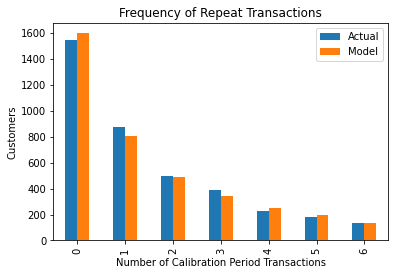

In [ ]:
## Assessing model fit: how good the model fit was
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

## Observations:
    # The below graphs shows number of period transactions predicted (x-axis) vs number of customers with that many period transactions (y-axis)
    # We can see that the model is able to predict almost equal number of customers as actual data
    # this shows that there is good fit for the model

#### Gamma - Gamma Model building. 
*   Without using holdout and calibration dataset



In [ ]:
## Checking if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation
## One assumption of gamma gamma model is -- monetary value and frequency are independent

lifetimes_summary_data[['monetary_value', 'frequency']].corr()

## Observation: as the correlation is close to 0, it simply refers very few correlation

,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


In [ ]:
## Picking those customers who had at least one repeat purchase with the company
returning_customers = lifetimes_summary_data[lifetimes_summary_data['frequency'] > 0]
print("The percentage of customer selected is: ", round((len(returning_customers) / len(lifetimes_summary_data))* 100,2), "%")

The percentage of customer selected is:  64.3 %


In [ ]:
print("The number of returning customers are: ", len(returning_customers))

The number of returning customers are:  2790


In [ ]:
## Training gamma-gamma model by taking into account the monetary_value

from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)

ggf.fit(returning_customers['frequency'],
	returning_customers['monetary_value'])

print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [ ]:
## Use of Gamma-Gamma model, to estimate average transaction value for each customer
ggf.conditional_expected_average_profit(
	lifetimes_summary_data['frequency'],
	lifetimes_summary_data['monetary_value']
	).head()

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
dtype: float64

In [ ]:
## creating a column to store the expected average profit per customer
lifetimes_summary_data['pred_avg_profit_value'] = round(ggf.conditional_expected_average_profit(
                                                                  lifetimes_summary_data['frequency'],
                                                                  lifetimes_summary_data['monetary_value']
                                                              ), 2)

lifetimes_summary_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,pred_10_days_transactions,pred_avg_profit_value
0,12346.0,0.0,0.0,325.0,0.000000,0.0,416.92
1,12347.0,6.0,365.0,367.0,599.701667,0.0,569.99
2,12348.0,3.0,283.0,358.0,301.480000,0.0,333.76
3,12349.0,0.0,0.0,18.0,0.000000,0.0,416.92
4,12350.0,0.0,0.0,310.0,0.000000,0.0,416.92


In [ ]:
## Finally the most important calculation
## Calculating the Customer Lifetime Value

lifetimes_summary_data['CLV'] = round(ggf.customer_lifetime_value(
                                                                  bgf, # the beta geo fitter model which is needed to predict the number of number of future transactions
                                                                  lifetimes_summary_data['frequency'],
                                                                  lifetimes_summary_data['recency'],
                                                                  lifetimes_summary_data['T'],
                                                                  lifetimes_summary_data['monetary_value'],
                                                                  time = 12, # number of months to consider in this calculation
                                                                  discount_rate = 0.01 # monthly discount rate ~ 12.7% annually
                                        ), 2)

lifetimes_summary_data.sort_values(by = 'CLV', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_10_days_transactions,pred_avg_profit_value,CLV
0,14646.0,44.0,353.0,354.0,6366.705909,1.0,6213.28,222128.93
1,18102.0,25.0,367.0,367.0,9349.477200,1.0,8951.86,178895.33
2,16446.0,1.0,205.0,205.0,168469.600000,0.0,78051.29,175531.47
3,17450.0,26.0,359.0,367.0,7404.690385,1.0,7105.09,147476.62
4,14096.0,16.0,97.0,101.0,4071.434375,1.0,3823.47,127589.20
5,14911.0,131.0,372.0,373.0,1093.661679,3.0,1087.70,109442.13
6,12415.0,15.0,313.0,337.0,7860.210000,0.0,7323.92,96290.23
7,14156.0,42.0,362.0,371.0,2787.081667,1.0,2723.13,89410.33
8,17511.0,27.0,371.0,373.0,3305.060741,1.0,3185.63,67660.41
9,16029.0,38.0,335.0,373.0,2034.808421,1.0,1986.70,58729.62


In [ ]:
CLV_data = lifetimes_summary_data.reset_index()[['CustomerID', 'CLV']]
CLV_data.sort_values(by='CLV', ascending=False).head()

,CustomerID,CLV
1690,14646.0,222128.93
4202,18102.0,178895.33
3009,16446.0,175531.47
3729,17450.0,147476.62
1290,14096.0,127589.20


#### Gamma - Gamma Model building. 
*   Using holdout and calibration dataset



In [ ]:
data.InvoiceDate.max() - data.InvoiceDate.min()
# The number of days the dataset is representing

datetime.timedelta(days=373)

In [ ]:
data.InvoiceDate.max()
# most recent date in the dataset

datetime.date(2011, 12, 9)

In [ ]:
data.InvoiceDate.min()
# oldest date in the dataset

datetime.date(2010, 12, 1)

In [ ]:
#### calibration period, holdout/observation period; these are train, test split
# calibration data: train data; holdout data: test data
#### in holdout dataset, we will have columns separated by _cal, and _holdout: _cal contains calibration period data, _holdout containing actual data

summary_cal_holdout = calibration_and_holdout_data(data, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', calibration_period_end='2011-10-01', observation_period_end='2011-12-09')
summary_cal_holdout.sort_values(by='frequency_holdout', ascending=False).head()


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
14911.0,93.0,303.0,304.0,1023.157419,38.0,23.714165,69.0
12748.0,80.0,303.0,304.0,246.405500,33.0,6.341639,69.0
17841.0,82.0,301.0,304.0,311.150488,29.0,5.254960,69.0
15311.0,68.0,300.0,304.0,706.229412,21.0,24.201417,69.0
12971.0,53.0,299.0,303.0,162.427925,17.0,31.701375,69.0


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


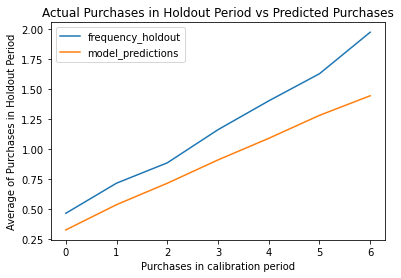

In [ ]:
### Re-fitting the model on the calibration period, so the model would be completely unaware of holdout data
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
#### plots the predicted frequency of orders in the holdout period to the actual value.


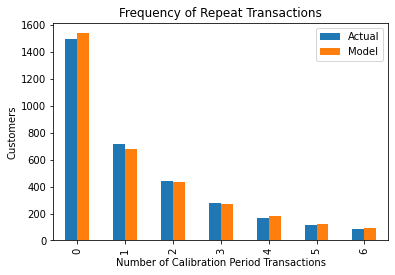

In [ ]:
## Assessing model fit: how good the model fit was using calibration dataset
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

## Observations:
    # The below graphs shows number of period transactions predicted (x-axis) vs number of customers with that many period transactions (y-axis)
    # We can see that the model is able to predict almost equal number of customers as actual data
    # this shows that there is good fit for the model

In [ ]:
## Checking if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation
## One assumption of gamma gamma model is -- monetary value and frequency are independent

summary_cal_holdout[['monetary_value_cal', 'frequency_cal']].corr()

## Observation: as the correlation is close to 0, it simply refers very few correlation

,monetary_value_cal,frequency_cal
monetary_value_cal,1.000000,0.238508
frequency_cal,0.238508,1.000000


In [ ]:
## Picking those customers who had at least one repeat purchase with the company
returning_customers_cal_holdout = summary_cal_holdout[(summary_cal_holdout['frequency_cal'] > 0) & (summary_cal_holdout['recency_cal'] > 0)]
print("The percentage of customer selected is: ", round((len(returning_customers_cal_holdout) / len(summary_cal_holdout))* 100,2), "%")

The percentage of customer selected is:  58.66 %


In [ ]:
## Checking if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation
## One assumption of gamma gamma model is -- monetary value and frequency are independent

returning_customers_cal_holdout[['monetary_value_cal', 'frequency_cal']].corr()

## Observation: as the correlation is close to 0, it simply refers very few correlation

,monetary_value_cal,frequency_cal
monetary_value_cal,1.000000,0.109118
frequency_cal,0.109118,1.000000


In [ ]:
## Training gamma-gamma model by taking into account the monetary_value

from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)

ggf.fit(returning_customers_cal_holdout['frequency_cal'],
	returning_customers_cal_holdout['monetary_value_cal'])

print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2121 subjects, p: 2.32, q: 3.32, v: 418.94>


In [ ]:
## creating a column to store the expected average profit per customer
returning_customers_cal_holdout['pred_avg_profit_value'] = round(ggf.conditional_expected_average_profit(
                                                                  returning_customers_cal_holdout['frequency_holdout'],
                                                                  returning_customers_cal_holdout['monetary_value_holdout']
                                                              ), 2)

returning_customers_cal_holdout.reset_index().head()

,CustomerID,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,pred_avg_profit_value
0,12347.0,4.0,238.0,298.0,519.7675,2.0,26.192069,69.0,157.18
1,12348.0,3.0,283.0,289.0,301.4800,0.0,0.000000,69.0,419.54
2,12352.0,5.0,224.0,227.0,379.5620,1.0,20.782000,69.0,220.02
3,12356.0,1.0,80.0,256.0,481.4600,1.0,29.175000,69.0,224.22
4,12359.0,2.0,142.0,262.0,1474.1150,1.0,27.398571,69.0,223.33


In [ ]:
## Finally the most important calculation
## Calculating the Customer Lifetime Value

returning_customers_cal_holdout['CLV'] = round(ggf.customer_lifetime_value(
                                                                  bgf, # the beta geo fitter model which is needed to predict the number of number of future transactions
                                                                  returning_customers_cal_holdout['frequency_cal'],
                                                                  returning_customers_cal_holdout['recency_cal'],
                                                                  returning_customers_cal_holdout['T_cal'],
                                                                  returning_customers_cal_holdout['monetary_value_cal'],
                                                                  time = 12, # number of months to consider in this calculation
                                                                  discount_rate = 0.01 # monthly discount rate ~ 12.7% annually
                                        ), 2)

returning_customers_cal_holdout.sort_values(by = 'CLV', ascending=False).head(10).reset_index()

,CustomerID,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,pred_avg_profit_value,CLV
0,14646.0,32.0,276.0,285.0,6344.865000,12.0,148.553719,69.0,169.37,192797.10
1,17450.0,18.0,297.0,298.0,8841.896667,8.0,411.948272,69.0,412.79,145067.98
2,18102.0,18.0,295.0,298.0,8568.835556,7.0,427.408011,69.0,426.43,140599.66
3,14156.0,31.0,301.0,302.0,3367.845806,11.0,74.001228,69.0,102.76,94754.75
4,12415.0,11.0,238.0,268.0,8643.318182,4.0,198.492609,69.0,242.65,93845.10
5,14911.0,93.0,303.0,304.0,1023.157419,38.0,23.714165,69.0,33.85,86357.45
6,17511.0,21.0,300.0,304.0,2979.983333,6.0,106.203147,69.0,150.91,56448.25
7,16029.0,32.0,293.0,304.0,1620.550625,6.0,553.589130,69.0,534.46,47012.95
8,17949.0,22.0,301.0,302.0,2335.600000,6.0,528.480000,69.0,512.94,46688.71
9,13694.0,29.0,302.0,304.0,1747.756552,5.0,150.139556,69.0,194.99,45924.74


#### References:
[The AI University Youtube Channel](https://github.com/nitinkaushik01/Deep_and_Machine_Learning_Projects/blob/master/Customer_Lifetime_Value/Customer_Lifetime_Value.ipynb)

[Gamma-Gamma PracticalDataScience](https://practicaldatascience.co.uk/data-science/how-to-calculate-clv-using-bgnbd-and-gamma-gamma)

[RFM Segmentation](https://practicaldatascience.co.uk/data-science/how-to-segment-customers-based-on-their-value-using-rfm-and-abc)